In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/raw/clients.csv")


In [2]:
FEATURES = [
    "age",
    "income",
    "credit_amount",
    "loan_duration",
    "employment_years"
]

X = df[FEATURES]
X_norm = (X - X.mean()) / X.std()

df["risk_score"] = (
    0.4 * X_norm["credit_amount"]
    + 0.3 * X_norm["loan_duration"]
    - 0.5 * X_norm["income"]
    - 0.4 * X_norm["employment_years"]
)


In [3]:
threshold = df["risk_score"].quantile(0.6)
df["accepted_baseline"] = (df["risk_score"] <= threshold).astype(int)

baseline_acceptance = df.groupby("sex")["accepted_baseline"].mean()
baseline_acceptance


sex
0    0.142857
1    1.000000
Name: accepted_baseline, dtype: float64

In [4]:
target_rate = df["accepted_baseline"].mean()

df["accepted_post"] = 0

for sex in [0, 1]:
    scores = df[df["sex"] == sex]["risk_score"]
    t = scores.quantile(target_rate)
    df.loc[(df["sex"] == sex) & (df["risk_score"] <= t), "accepted_post"] = 1

post_acceptance = df.groupby("sex")["accepted_post"].mean()
post_acceptance


sex
0    0.571429
1    0.625000
Name: accepted_post, dtype: float64

In [5]:
comparison = pd.DataFrame({
    "Baseline": baseline_acceptance,
    "Post-processing": post_acceptance
})

comparison


,Baseline,Post-processing
sex,,
0,0.142857,0.571429
1,1.000000,0.625000


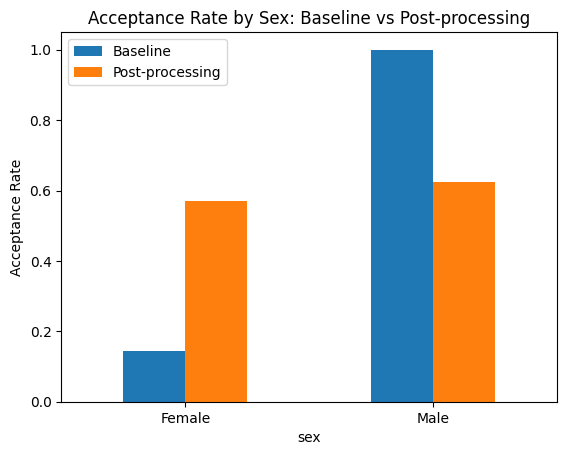

In [6]:
comparison.plot(kind="bar")
plt.title("Acceptance Rate by Sex: Baseline vs Post-processing")
plt.ylabel("Acceptance Rate")
plt.xticks([0,1], ["Female", "Male"], rotation=0)
plt.show()


Le post-processing permet de corriger partiellement les inégalités de décision
en ajustant les seuils d’acceptation après le calcul du score de risque.

Cette approche est simple à mettre en œuvre et ne nécessite pas de modifier
le modèle de scoring. En revanche, elle n’intègre pas explicitement les contraintes
d’équité dans le processus d’optimisation et ne garantit pas un contrôle fin
du compromis entre performance et équité.

Ces limites motivent l’utilisation d’approches d’in-processing, où les contraintes
d’équité sont directement intégrées dans la prise de décision.